In [1]:
import mwtab
import pandas as pd
import numpy as np

# scikit
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

# My code
import data.mwtab_fxns as my_mwtab
import data.preprocessing as preproc
import project_fxns.rt_window_prediction as rtwin


%load_ext autoreload
%autoreload 2

/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
local_path = '/home/irockafe/Dropbox (MIT)/Alm_Lab/projects/'
project_path = '/revo_healthcare/data/processed/ST000450/pos/'
neg = '/ST000450_AN000706_negative_hilic.txt'
pos = '/ST000450_AN000705_positive_hilic.txt'

In [3]:
mwtfile_gen = mwtab.read_files(local_path+project_path+pos)
mwtfile = next(mwtfile_gen)

In [4]:
print mwtfile.keys()
mwtab_df = pd.DataFrame(mwtfile['MS_METABOLITE_DATA']['MS_METABOLITE_DATA_START']['DATA'])

['METABOLOMICS WORKBENCH', 'PROJECT', 'STUDY', 'SUBJECT', 'SUBJECT_SAMPLE_FACTORS', 'COLLECTION', 'TREATMENT', 'SAMPLEPREP', 'CHROMATOGRAPHY', 'ANALYSIS', 'MS', 'MS_METABOLITE_DATA', 'METABOLITES']


## Get feature table and metadata
ensure they're in the same order

In [5]:
metadata_df = my_mwtab.factors_to_df(mwtfile)
df = my_mwtab.get_feature_table(mwtfile)
assert(metadata_df.index == df.index).all()
print 'df shape', df.shape
print 'metadata shape', metadata_df.shape
metadata_df.head()

you'll probably have to conver this dataframe to float after youreplace null values
df shape (84, 226)
metadata shape (84, 2)


,gender,Disease
101,Female,CFS
105,Female,CFS
107,Female,CFS
108,Female,CFS
112,Female,CFS


In [6]:
# convert classes to numbers
le = preprocessing.LabelEncoder()
le.fit(metadata_df['Disease'])
y = le.transform(metadata_df['Disease'])
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Preprocess feature table
Correct for dilution factors, fill nan values

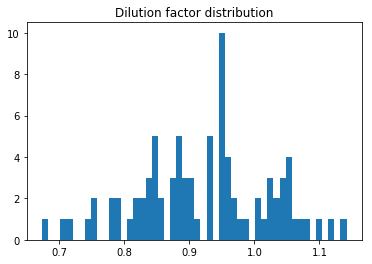

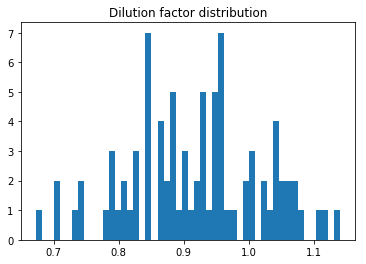

In [7]:
# Replace NaNs
df = df.replace('\N', np.nan)
df = df.astype(float)

# Fill with half the min value
fill_val = df.min(axis=1).min() / 2
df_filled = df.fillna(value=fill_val)
df_filled
df_pqn_raw = preproc.correct_dilution_factor(df, plot=True)
df_pqn_filled = preproc.correct_dilution_factor(df_filled, plot=True)

## Separate by case and control
May wanna separate by gender later, too

In [8]:
print "classes: {c}".format(c = metadata_df['Disease'].unique())
#print (metadata_df.T['Disease'] == 'CFS')
case_labels = metadata_df[metadata_df['Disease'] == 'CFS'].index
control_labels = metadata_df[metadata_df['Disease'] == 'Normal'].index

classes: ['CFS' 'Normal']


## Check for obvious differences in intensity distribution between case & control

raw data



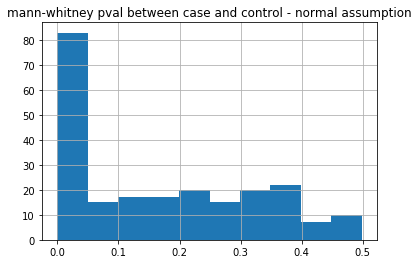

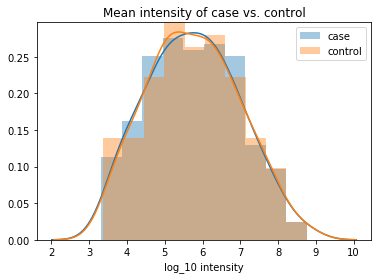

pval (MannW) of intensities between case and control:  0.476311277098
raw data, nan filled


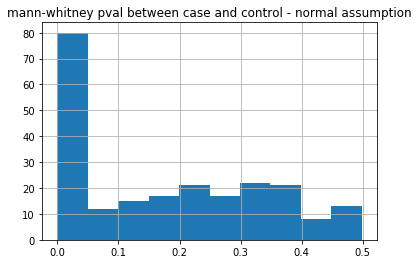

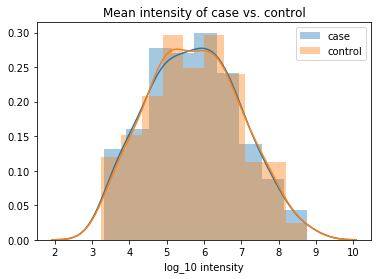

pval (MannW) of intensities between case and control:  0.466568196539
pqn-data nan filled


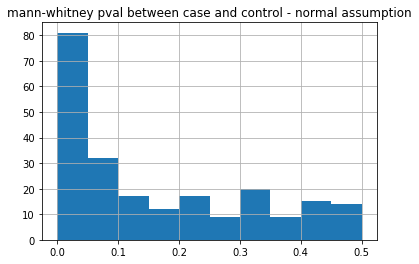

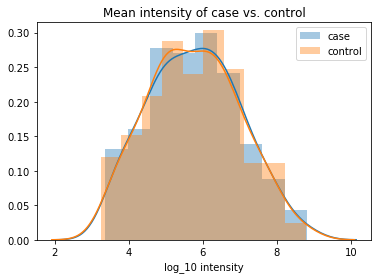

pval (MannW) of intensities between case and control:  0.414334040565


In [160]:
def mw_pval_dist(case, control):
    '''
    case - dataframe containing case
    control - dataframe with control samples
        All should have same features (columns)
    '''
    # get parametric pvals
    mann_whitney_vals = pd.DataFrame(np.full([case.shape[1],2], np.nan),
                              index=case.columns, columns= ['u', 'pval'])
    for idx, case_vals in case.iteritems():
        control_vals = control[idx]
        u, pval = stats.mannwhitneyu(case_vals, control_vals)
        mann_whitney_vals.loc[idx, 'u'] = u
        mann_whitney_vals.loc[idx, 'pval'] = pval
    
    # plot mw pval distribution
    mann_whitney_vals.hist('pval')
    plt.title('mann-whitney pval between case and control - normal assumption')
    plt.show()
    
    # plot distribution of mean intensities
    case_mean = case.mean(axis=0)
    ctrl_mean = control.mean(axis=0)
    sns.distplot(np.log10(case_mean), label='case')
    sns.distplot(np.log10(ctrl_mean), label='control')
    plt.xlabel('log_10 intensity')
    plt.title('Mean intensity of case vs. control')
    plt.legend()
    plt.show()
    u, pval = stats.mannwhitneyu(case_mean, ctrl_mean)
    print 'pval (MannW) of intensities between case and control: ', pval

print "raw data, nan filled"
mw_pval_dist(df_filled.loc[case_labels], df_filled.loc[control_labels])

print "pqn-data nan filled"
mw_pval_dist(df_pqn_filled.loc[case_labels], df_pqn_filled.loc[control_labels])

0.0% done! 0.370579957962s elapsed
20.0% done! 3.34811902046s elapsed
40.0% done! 6.22305297852s elapsed
60.0% done! 9.1010248661s elapsed
80.0% done! 11.963285923s elapsed
Plottttt!
0.0% done! 0.373498916626s elapsed
Plottttt!
Number of differences b/t original andshuffle: 48
0.0% done! 0.309057950974s elapsed
Number of differences b/t original andshuffle: 40
0.0% done! 0.319176912308s elapsed
Number of differences b/t original andshuffle: 44
0.0% done! 0.307043075562s elapsed
Number of differences b/t original andshuffle: 42
0.0% done! 0.397749185562s elapsed
Number of differences b/t original andshuffle: 40
0.0% done! 0.316708087921s elapsed
Number of differences b/t original andshuffle: 46
0.0% done! 0.314167022705s elapsed
Number of differences b/t original andshuffle: 44
0.0% done! 0.31925201416s elapsed
Number of differences b/t original andshuffle: 46
0.0% done! 0.334133148193s elapsed
Number of differences b/t original andshuffle: 42
0.0% done! 0.32973408699s elapsed
Number of

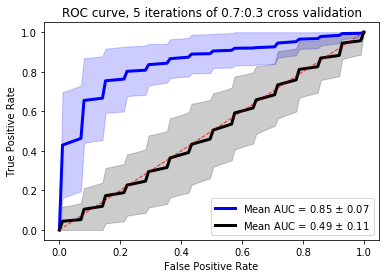

In [34]:
random_state = 1
test_size = 0.3
n_iter = 50
n_trees = 100
cross_val = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size,
                                  random_state=random_state)
clf = RandomForestClassifier(n_estimators=n_trees,
                            random_state=random_state)


auc_vals = rtwin.roc_curve_cv(df_pqn_filled.as_matrix(), y, clf, cross_val,
                  save=False, plot=False)

cross_val = StratifiedShuffleSplit(y, n_iter=5, test_size=test_size,
                                  random_state=random_state)
auc_vals = rtwin.roc_curve_cv_null(df_pqn_filled.as_matrix(), y, clf, cross_val,
                  num_shuffles=20, save=False, plot=False)

auc_vals.show()

In [45]:
a = [1,2,3] 
b = [4,5,6]
a.append(b)
print a
print b

[1, 2, 3, [4, 5, 6]]
[4, 5, 6]
